Brooklyn Crime 

Phases
1) Data Mining
2) Data Exploration & Data Cleaning
3) Feature Engineering 
4) Predictive Modeling 
5) Visualization & Presentation

1) Data Mining

In [5]:
#Importing Libraries
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from shapely.geometry import Point
import csv
import os
from sklearn.impute import SimpleImputer

from datetime import date
from sodapy import Socrata

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

from geopy.geocoders import Nominatim



print("Libraries imported successfully...")

Libraries imported successfully...


In [6]:
####Loading data  from city of new york API
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:


client = Socrata("data.cityofnewyork.us", None)
    
# Example authenticated client (needed for non-public datasets)
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken
#                  username=\"user@example.com\
#                  password=\"AFakePassword\")
    
# First 2000 results, returned as JSON from API 
# dictionaries by sodapy

##Removing missing  values in Complaints_df
query = f"""
SELECT * 

WHERE boro_nm ="BROOKLYN"
    AND susp_race IS NOT NULL
    AND susp_sex IS NOT NULL
    AND susp_age_group IS NOT NULL
    AND cmplnt_to_dt  IS NOT NULL
    AND cmplnt_to_tm IS NOT NULL
    AND vic_age_group  IS NOT NULL
    AND cmplnt_fr_dt
BETWEEN '2020-01-01' AND '2022-12-31' 

LIMIT 100000

"""
    
#COMPLAINTS
Complaints = client.get("5uac-w243", query = query)
    
# Convert to pandas DataFrame 
Complaints_df = pd.DataFrame.from_records(Complaints)
Complaints_df = Complaints_df.loc[Complaints_df.boro_nm=='BROOKLYN'].copy()

    
#By far the largest df This program can use
    
    
#Zillow
Zillow = pd.read_csv(r'D:\Brooklyn Crime\Brooklyn-Crime\zillow NY for-sale properties.csv')

Zillow = Zillow.loc[Zillow.city.isin(['Brooklyn'])]






In [7]:
#CENSUS
query = f"""
SELECT * 

WHERE borough ="Brooklyn"
    
LIMIT 100000

"""
Census = client.get("swpk-hqdp", query = query)
    
# Convert to pandas DataFrame 
Census_df = pd.DataFrame.from_records(Census)


2) Data Cleaning and Data Exploration

In [8]:
#Columns list for Zillow

count = 0
for col in Zillow.columns:
    print(col)
    count+= 1

print("Number of columns are: ",count,)

property_url
property_id
address
street_name
apartment
city
state
latitude
longitude
postcode
price
bedroom_number
bathroom_number
price_per_unit
living_space
land_space
land_space_unit
broker_id
property_type
property_status
year_build
total_num_units
listing_age
RunDate
agency_name
agent_name
agent_phone
is_owned_by_zillow
Number of columns are:  28


In [9]:
#Columns list for Complaints_df
count = 0
for col in Complaints_df.columns:
    print(col)
    count+= 1

print("Number of columns are: ",count,)

cmplnt_num
addr_pct_cd
boro_nm
cmplnt_fr_dt
cmplnt_fr_tm
cmplnt_to_dt
cmplnt_to_tm
crm_atpt_cptd_cd
hadevelopt
jurisdiction_code
juris_desc
ky_cd
law_cat_cd
loc_of_occur_desc
ofns_desc
parks_nm
patrol_boro
pd_cd
pd_desc
prem_typ_desc
rpt_dt
station_name
susp_age_group
susp_race
susp_sex
vic_age_group
vic_race
vic_sex
x_coord_cd
y_coord_cd
latitude
longitude
lat_lon
geocoded_column
housing_psa
transit_district
Number of columns are:  36


In [10]:
#Columns list for Census_df
count = 0
for col in Census_df.columns:
    print(col)
    count+= 1

print("Number of columns are: ",count,)

borough
year
fips_county_code
nta_code
nta_name
population
Number of columns are:  6


In [11]:
Complaints_df.loc[:,['lat_lon']]

,lat_lon
0,"{'latitude': '40.6488507469884', 'longitude': ..."
1,"{'latitude': '40.634565', 'longitude': '-73.92..."
2,"{'latitude': '40.672873', 'longitude': '-73.92..."
3,"{'latitude': '40.681887', 'longitude': '-73.91..."
4,"{'latitude': '40.677101', 'longitude': '-74.01..."
...,...
99995,"{'latitude': '40.718524', 'longitude': '-73.96..."
99996,"{'latitude': '40.641002', 'longitude': '-73.99..."
99997,"{'latitude': '40.57510031', 'longitude': '-73...."
99998,"{'latitude': '40.630932', 'longitude': '-73.91..."


        a) Data Cleaning

        i) Missing values

In [12]:
# get the number of missing data points per column in Complaints_df
missing_values_count_Complaints = Complaints_df.isnull().sum()

# look at the # of missing points
missing_values_count_Complaints

##Relevant Null vallues dropped in mining via query. 

cmplnt_num               0
addr_pct_cd              0
boro_nm                  0
cmplnt_fr_dt             0
cmplnt_fr_tm             0
cmplnt_to_dt             0
cmplnt_to_tm             0
crm_atpt_cptd_cd         0
hadevelopt               0
jurisdiction_code        0
juris_desc               0
ky_cd                    0
law_cat_cd               0
loc_of_occur_desc        0
ofns_desc                0
parks_nm                 0
patrol_boro              0
pd_cd                    0
pd_desc                  0
prem_typ_desc            0
rpt_dt                   0
station_name             0
susp_age_group           0
susp_race                0
susp_sex                 0
vic_age_group            0
vic_race                 0
vic_sex                  0
x_coord_cd               0
y_coord_cd               0
latitude                 0
longitude                0
lat_lon                  0
geocoded_column          0
housing_psa          92014
transit_district     97947
dtype: int64

In [13]:
#Adding weekdays
Complaints_df["cmplnt_fr_dt"]= Complaints_df['cmplnt_fr_dt'].astype('datetime64[ns]')
Complaints_df.dtypes
Complaints_df["Weekdays"] = Complaints_df['cmplnt_fr_dt'].dt.dayofweek
Complaints_df.loc[:,['cmplnt_fr_dt', 'Weekdays' ]]

,cmplnt_fr_dt,Weekdays
0,2021-01-01,4
1,2022-01-01,5
2,2021-11-16,1
3,2021-01-01,4
4,2021-12-23,3
...,...,...
99995,2022-09-17,5
99996,2022-09-13,1
99997,2022-09-19,0
99998,2022-09-17,5


In [14]:
#Converting locations into real numbers for Zillow


dict_columns_type = {'longitude': float,
                'latitude': float
               }
               
   
Zillow = Zillow.astype(dict_columns_type)
Zillow.loc[:,['longitude', 'latitude']]

,longitude,latitude
49324,-73.924180,40.586697
49328,-73.924995,40.586310
49332,-73.920425,40.587380
49335,-73.922060,40.589123
49338,-73.922030,40.586940
...,...,...
96739,-74.005810,40.630190
96740,-74.006645,40.634407
96741,-73.908560,40.658512
96742,-73.913100,40.666252


In [15]:
# get the number of missing data points per column in Zillow
missing_values_count_zillow = Zillow.isnull().sum()

# look at the # of missing points
missing_values_count_zillow




property_url             0
property_id              0
address                  0
street_name              0
apartment             7130
city                     0
state                    0
latitude                92
longitude               92
postcode                 0
price                    0
bedroom_number         560
bathroom_number         81
price_per_unit        1298
living_space          1287
land_space            5377
land_space_unit       5377
broker_id             9901
property_type            0
property_status          0
year_build            9901
total_num_units       9901
listing_age              0
RunDate                  0
agency_name            133
agent_name            9901
agent_phone           9901
is_owned_by_zillow       0
dtype: int64

In [16]:
# get the number of missing data points per column in Complaints_df
missing_values_count_Census = Census_df.isnull().sum()

# look at the # of missing points
missing_values_count_Census

borough             0
year                0
fips_county_code    0
nta_code            0
nta_name            0
population          0
dtype: int64

    ii) Fixing Locations and precincts

In [17]:
#Converting locations into real numbers for Complaints_df

dict_columns_type = {'longitude': float,
                'latitude': float
               }
   
Complaints_df = Complaints_df.astype(dict_columns_type)
Complaints_df.loc[:,['longitude', 'latitude']]

,longitude,latitude
0,-73.951017,40.648851
1,-73.928086,40.634565
2,-73.923688,40.672873
3,-73.919793,40.681887
4,-74.010482,40.677101
...,...,...
99995,-73.960317,40.718524
99996,-73.991444,40.641002
99997,-73.998557,40.575100
99998,-73.918479,40.630932


GeoData

In [18]:
#Precincts and Complaints_df
precincts = gpd.read_file(r"D:\Brooklyn Crime\Brooklyn-Crime\Police Precincts\geo_export_cd0a4750-fe4c-4415-9f05-3e7f0f353d91.shp")

precincts.crs={'init': 'epsg:32630'}

Complaints_mp = gpd.GeoDataFrame(Complaints_df, geometry=gpd.points_from_xy(Complaints_df.longitude, Complaints_df.latitude))
Complaints_mp.crs = {'init': 'epsg:32630'}


precincts = precincts.loc[precincts.precinct.isin([60.0,
    61.0,
    62.0,
    63.0,
    66.0,
    67.0,
    68.0,
    69.0,
    70.0,
    71.0,
    72.0,
    73.0,
    75.0,
    76.0,
    77.0,
    78.0,
    79.0,
    81.0,
    83.0,
    84.0,
    88.0,
    90.0,
    94.0
    ])].copy()

precincts

c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-ch

,precinct,shape_area,shape_leng,geometry
38,60.0,8.819777e+07,66061.055561,"POLYGON ((-73.98372 40.59582, -73.98305 40.595..."
39,61.0,1.346798e+08,131921.596137,"MULTIPOLYGON (((-73.89542 40.57676, -73.89528 ..."
40,62.0,1.032265e+08,51711.956978,"POLYGON ((-73.97299 40.60881, -73.97296 40.608..."
41,63.0,2.294649e+08,203661.472934,"MULTIPOLYGON (((-73.91719 40.58568, -73.91719 ..."
42,66.0,9.948685e+07,52388.611368,"POLYGON ((-73.97140 40.64826, -73.97121 40.647..."
43,67.0,9.381497e+07,43255.869527,"POLYGON ((-73.90755 40.65119, -73.90849 40.650..."
44,68.0,1.110163e+08,44460.160105,"POLYGON ((-74.03288 40.64358, -74.03284 40.643..."
45,69.0,1.068387e+08,116837.655799,"MULTIPOLYGON (((-73.84674 40.60485, -73.84672 ..."
46,70.0,8.217188e+07,49075.568430,"POLYGON ((-73.95630 40.65505, -73.95616 40.653..."
47,71.0,4.531538e+07,29932.804499,"POLYGON ((-73.92872 40.66450, -73.92905 40.664..."


In [19]:
#Zillow
print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(Zillow["latitude"])) / len(Zillow)) * 100))

# Drop Places that were not successfully geocoded
Zillow = Zillow.loc[~np.isnan(Zillow["latitude"])]
Zillow_mp = gpd.GeoDataFrame(
    Zillow, geometry=gpd.points_from_xy(Zillow.longitude, Zillow.latitude))
Zillow_mp.crs = {'init': 'epsg:32630'}
Zillow_mp

99.07080092919907% of addresses were geocoded!


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,property_url,property_id,address,street_name,apartment,city,state,latitude,longitude,postcode,...,property_status,year_build,total_num_units,listing_age,RunDate,agency_name,agent_name,agent_phone,is_owned_by_zillow,geometry
49324,https://www.zillow.com/homedetails/10-Just-Ct-...,30793415,"10 Just Ct, Brooklyn, NY 11229",Just Ct,NaN,Brooklyn,NY,40.586697,-73.924180,11229.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: Your Home Sold Guaranteed Real,NaN,NaN,0,POINT (-73.92418 40.58670)
49328,https://www.zillow.com/homedetails/8-Seba-Ave-...,30793465,"8 Seba Ave, Brooklyn, NY 11229",Seba Ave,NaN,Brooklyn,NY,40.586310,-73.924995,11229.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: Winzone Realty Inc,NaN,NaN,0,POINT (-73.92499 40.58631)
49332,https://www.zillow.com/homedetails/28-Lois-Ave...,30793324,"28 Lois Ave, Brooklyn, NY 11229",Lois Ave,NaN,Brooklyn,NY,40.587380,-73.920425,11229.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: Doreen Greenwood Inc.,NaN,NaN,0,POINT (-73.92042 40.58738)
49335,https://www.zillow.com/homedetails/66-Beacon-C...,30794032,"66 Beacon Ct, Brooklyn, NY 11229",Beacon Ct,NaN,Brooklyn,NY,40.589123,-73.922060,11229.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: Tracey Real Estate,NaN,NaN,0,POINT (-73.92206 40.58912)
49338,https://www.zillow.com/homedetails/25-Frank-Ct...,30793945,"25 Frank Ct, Brooklyn, NY 11229",Frank Ct,NaN,Brooklyn,NY,40.586940,-73.922030,11229.0,...,PENDING,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: eXp Realty BKNY,NaN,NaN,0,POINT (-73.92203 40.58694)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96739,https://www.zillow.com/homedetails/1048-63rd-S...,30689052,"1048 63rd St, Brooklyn, NY 11219",63rd St,NaN,Brooklyn,NY,40.630190,-74.005810,11219.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: Nest Seekers,NaN,NaN,0,POINT (-74.00581 40.63019)
96740,https://www.zillow.com/homedetails/908-59th-St...,142948514,"908 59th St, Brooklyn, NY 11219",59th St,NaN,Brooklyn,NY,40.634407,-74.006645,11219.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Listing by: RE/MAX Real Estate Professionals,NaN,NaN,0,POINT (-74.00665 40.63441)
96741,https://www.zillow.com/homedetails/531-Chester...,30633344,"531 Chester St, Brooklyn, NY 11212",Chester St,NaN,Brooklyn,NY,40.658512,-73.908560,11212.0,...,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,NaN,NaN,NaN,0,POINT (-73.90856 40.65851)
96742,https://www.zillow.com/homedetails/588-Thomas-...,30632177,"588 Thomas S Boyland St, Brooklyn, NY 11212",Thomas S Boyland St,NaN,Brooklyn,NY,40.666252,-73.913100,11212.0,...,PENDING,NaN,NaN,-1,2022-04-24 07:34:15,NaN,NaN,NaN,0,POINT (-73.91310 40.66625)


In [20]:
#Geocoding Census
geolocator = Nominatim(user_agent="Don")
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'latitude': point.latitude, 'longitude': point.longitude})
    except:
        return None

Census_df[['latitude', 'longitude']] = Census_df.apply(lambda x: my_geocoder(x['nta_name']), axis=1)



In [21]:
print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(Census_df["latitude"])) / len(Census_df)) * 100))

# Drop Places that were not successfully geocoded
Census_df = Census_df.loc[~np.isnan(Census_df["latitude"])]
Census_mp = gpd.GeoDataFrame(
    Census_df, geometry=gpd.points_from_xy(Census_df.longitude, Census_df.latitude))
Census_mp.crs = {'init': 'epsg:32630'}
Census_mp.head()

86.27450980392157% of addresses were geocoded!


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,borough,year,fips_county_code,nta_code,nta_name,population,latitude,longitude,geometry
0,Brooklyn,2000,047,BK09,Brooklyn Heights-Cobble Hill,22548,40.690222,-73.994895,POINT (-73.99489 40.69022)
2,Brooklyn,2000,047,BK19,Brighton Beach,35244,40.579644,-73.961110,POINT (-73.96111 40.57964)
3,Brooklyn,2000,047,BK21,Seagate-Coney Island,34267,40.580117,-74.006141,POINT (-74.00614 40.58012)
4,Brooklyn,2000,047,BK23,West Brighton,17370,40.577778,-73.974935,POINT (-73.97493 40.57778)
5,Brooklyn,2000,047,BK25,Homecrest,45679,42.090786,-80.087171,POINT (-80.08717 42.09079)


    iii) Mapping

<AxesSubplot:>

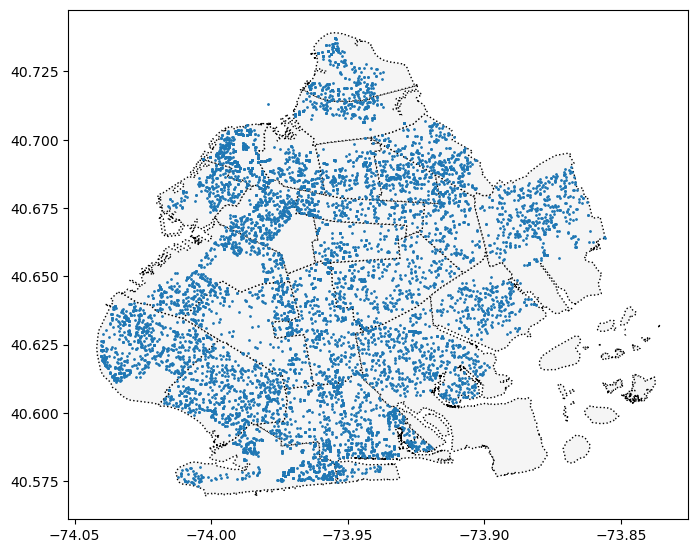

In [22]:
# Create a map for Zillow_mp
ax = precincts.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
Zillow_mp.plot(markersize=1, ax=ax)

<AxesSubplot:>

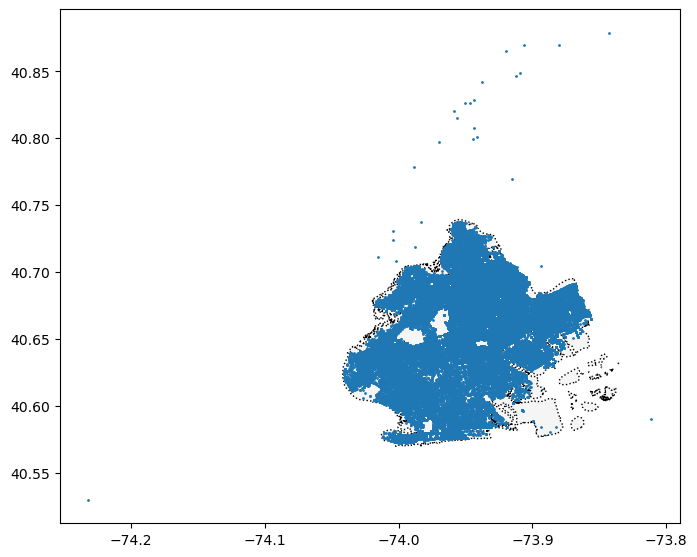

In [23]:
# Create a map for Complaints_mp
ax = precincts.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
Complaints_mp.plot(markersize=1, ax=ax)

NB/= The locations with no records of complaints or properties are mostly parks

    iv) Merging with precincts

In [24]:
#Using spatial join to assign precincts to Neighborhood
Zillow_mp = gpd.sjoin(Zillow_mp, precincts)


In [25]:
#Dropping addr_pct_cd
Complaints_df.drop('addr_pct_cd', axis=1, inplace=True)

In [26]:
#Replacing addr_pct_cd with precincts
Complaints_mp = gpd.sjoin(Complaints_mp, precincts)

Complaints_mp.dtypes
#TODO: Separate categorical data and numeric data 
#TODO: Apply Neighborhood features to Complaints data.

cmplnt_num                   object
addr_pct_cd                  object
boro_nm                      object
cmplnt_fr_dt         datetime64[ns]
cmplnt_fr_tm                 object
cmplnt_to_dt                 object
cmplnt_to_tm                 object
crm_atpt_cptd_cd             object
hadevelopt                   object
jurisdiction_code            object
juris_desc                   object
ky_cd                        object
law_cat_cd                   object
loc_of_occur_desc            object
ofns_desc                    object
parks_nm                     object
patrol_boro                  object
pd_cd                        object
pd_desc                      object
prem_typ_desc                object
rpt_dt                       object
station_name                 object
susp_age_group               object
susp_race                    object
susp_sex                     object
vic_age_group                object
vic_race                     object
vic_sex                     

In [27]:
#Joining precinct with census
Census_mp = gpd.sjoin(Census_mp, precincts)
